# Neural Network to classify healthy and non-healthy Tuberculosis (TB) manifestations with chest X-rays

Install and import necessary dependencies

In [90]:
! pip install torch torchvision scikit-learn --quiet

In [91]:
import time
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model

# Data preprocessing

Funtion to load the dataset

In [92]:
class ChestXRayDataset:
    def __init__(self, image_dir, metadata_dir, left_mask_dir, right_mask_dir, transform=None):
        self.image_dir = image_dir
        self.metadata_dir = metadata_dir
        self.left_mask_dir = left_mask_dir
        self.right_mask_dir = right_mask_dir
        
        self.data = []
        self.labels = []
        
        # Images will be resized to 100x100 pixels
        self.image_shape = (100, 100)

        # Initialize images and labels
        self.load_data()

    def load_data(self):
        for img_name in os.listdir(self.image_dir):
            if img_name.endswith('.png'): # Only process PNG files
                try:
                    # Load image
                    img_path = os.path.join(self.image_dir, img_name)

                    # Number of gray levels is 12bits, so we read the image with the original image depth (number of channels)
                    img_array = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

                    # Equalize histogram to improve contrast in images
                    img_array = cv2.equalizeHist(img_array)

                    # Resize image to 100x100 pixels for faster training and less memory usage
                    resized_img = cv2.resize(img_array, self.image_shape)

                    # Load lung masks
                    left_mask_path = os.path.join(self.left_mask_dir, img_name)
                    right_mask_path = os.path.join(self.right_mask_dir, img_name)
                    left_mask = cv2.imread(left_mask_path, cv2.IMREAD_GRAYSCALE)
                    right_mask = cv2.imread(right_mask_path, cv2.IMREAD_GRAYSCALE)

                    # Combine masks
                    combined_mask = cv2.bitwise_or(left_mask, right_mask)
                    combined_mask = cv2.resize(combined_mask, self.image_shape)

                    # Apply mask to image
                    masked_img = cv2.bitwise_and(resized_img, resized_img, mask=combined_mask)

                    # Extract labels from file name suffix
                    #  ‘0’ represents the normal and ‘1’ represents the abnormal lung.
                    label = int(img_name.replace('.png', '')[-1])

                    self.data.append(masked_img)
                    self.labels.append(label) 

                except Exception as e:
                    print(f"Error loading image {img_name}: {e}")

        # Normalize data to range [0, 1] and convert to numpy array
        # Also reshape data to 4D tensor (batch_size, height, width, channels) for CNN
        self.data = np.array(self.data).reshape(-1, 100, 100, 1) / 4095.0
        self.labels = np.array(self.labels).astype(np.float32)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        return image, label

Load the dataset

In [93]:
dataset = ChestXRayDataset(
    image_dir='./data/CXR_png',
    metadata_dir='./data/ClinicalReadings',
    left_mask_dir='./data/ManualMask/leftMask',
    right_mask_dir='./data/ManualMask/rightMask',
)

print(f"Data shape: {dataset.data.shape}")
print(f"Labels shape: {dataset.labels.shape}")

Data shape: (138, 100, 100, 1)
Labels shape: (138,)


Visualize the first 8 images from the dataset

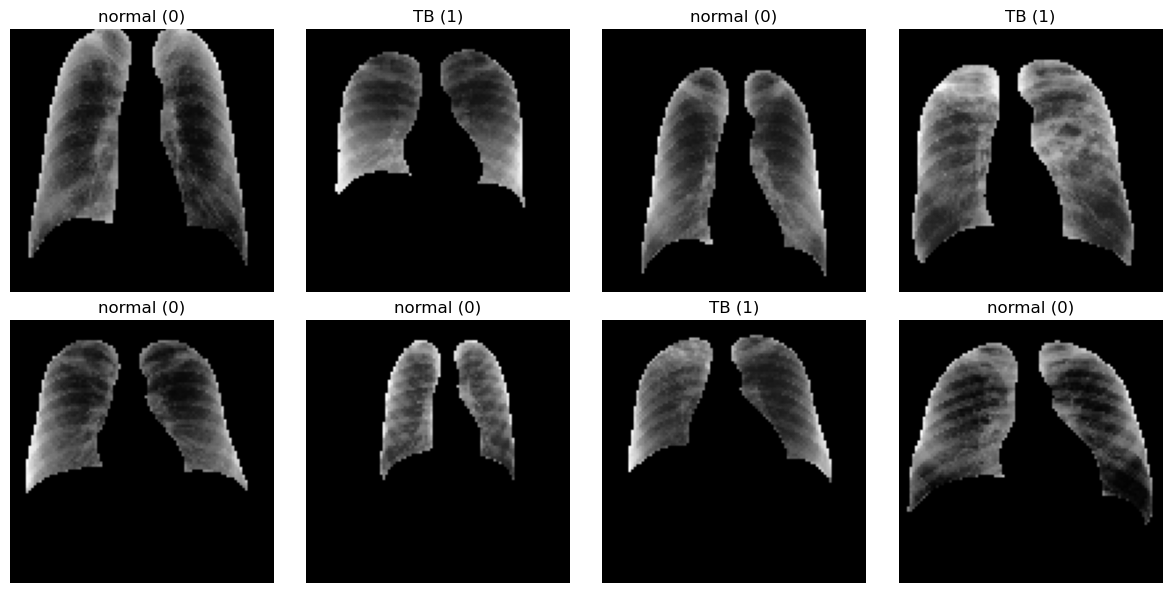

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i in range(8):
    ax = axes[i // 4, i % 4]
    image, label = dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title('TB (1)' if label == 1 else 'normal (0)')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data Split

In [95]:
X_train, X_temp, y_train, y_temp = train_test_split(dataset.data, dataset.labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (110, 100, 100, 1)
Validation set: (14, 100, 100, 1)
Test set: (14, 100, 100, 1)


# Data augmentation

In [96]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

# Model Architecture with DenseNet169

In [97]:
class TBNet:
    def __init__(self, input_shape=(100, 100, 1)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=self.input_shape),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def compile(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def summary(self):
        return self.model.summary()

In [98]:
model = TBNet().model
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,329 (6.60 MB)

 Trainable params: 1,731,329 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

# Model Compilation

In [99]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Training

In [100]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)

Epoch 1/20


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4674 - loss: 0.6931 

/Users/mzitoh/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4837 - loss: 0.6931 - val_accuracy: 0.6429 - val_loss: 0.6929
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4688 - loss: 0.4621 - val_accuracy: 0.6429 - val_loss: 0.6928
Epoch 3/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5000 - loss: 0.6931

2024-06-02 19:30:15.866287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/mzitoh/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5084 - loss: 0.6932 - val_accuracy: 0.6429 - val_loss: 0.6928
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5625 - loss: 0.4620 - val_accuracy: 0.6429 - val_loss: 0.6927
Epoch 5/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5938 - loss: 0.6929

2024-06-02 19:30:16.252396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5481 - loss: 0.6931 - val_accuracy: 0.6429 - val_loss: 0.6926
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5625 - loss: 0.4619 - val_accuracy: 0.6429 - val_loss: 0.6926
Epoch 7/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3571 - loss: 0.6937

2024-06-02 19:30:16.723369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4816 - loss: 0.6933 - val_accuracy: 0.6429 - val_loss: 0.6925
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6250 - loss: 0.4617 - val_accuracy: 0.6429 - val_loss: 0.6925
Epoch 9/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5625 - loss: 0.6929

2024-06-02 19:30:17.119868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5697 - loss: 0.6928 - val_accuracy: 0.6429 - val_loss: 0.6923
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4688 - loss: 0.4622 - val_accuracy: 0.6429 - val_loss: 0.6923
Epoch 11/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5312 - loss: 0.6930

2024-06-02 19:30:17.498719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5651 - loss: 0.6927 - val_accuracy: 0.6429 - val_loss: 0.6921
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2857 - loss: 0.4632 - val_accuracy: 0.6429 - val_loss: 0.6920
Epoch 13/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5938 - loss: 0.6924

2024-06-02 19:30:17.936282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5647 - loss: 0.6927 - val_accuracy: 0.6429 - val_loss: 0.6919
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5312 - loss: 0.4619 - val_accuracy: 0.6429 - val_loss: 0.6919
Epoch 15/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6429 - loss: 0.6919

2024-06-02 19:30:18.340027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5540 - loss: 0.6925 - val_accuracy: 0.6429 - val_loss: 0.6917
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5938 - loss: 0.4615 - val_accuracy: 0.6429 - val_loss: 0.6916
Epoch 17/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6562 - loss: 0.6915

2024-06-02 19:30:18.722057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5983 - loss: 0.6923 - val_accuracy: 0.6429 - val_loss: 0.6914
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.4621 - val_accuracy: 0.6429 - val_loss: 0.6914
Epoch 19/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5312 - loss: 0.6928

2024-06-02 19:30:19.177182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5443 - loss: 0.6925 - val_accuracy: 0.6429 - val_loss: 0.6912
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5312 - loss: 0.4618 - val_accuracy: 0.6429 - val_loss: 0.6911


2024-06-02 19:30:19.561305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Model Evaluation

In [101]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    cm = confusion_matrix(y_test, y_pred_classes)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    sensitivity = recall  
    auc = roc_auc_score(y_test, y_pred)
    
    metrics_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'Sensitivity', 'AUC'],
        'Value': [accuracy, precision, recall, specificity, sensitivity, auc]
    }
    
    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
     Metric    Value
   Accuracy 0.785714
  Precision 0.000000
     Recall 0.000000
Specificity 1.000000
Sensitivity 0.000000
        AUC 0.575758


/Users/mzitoh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


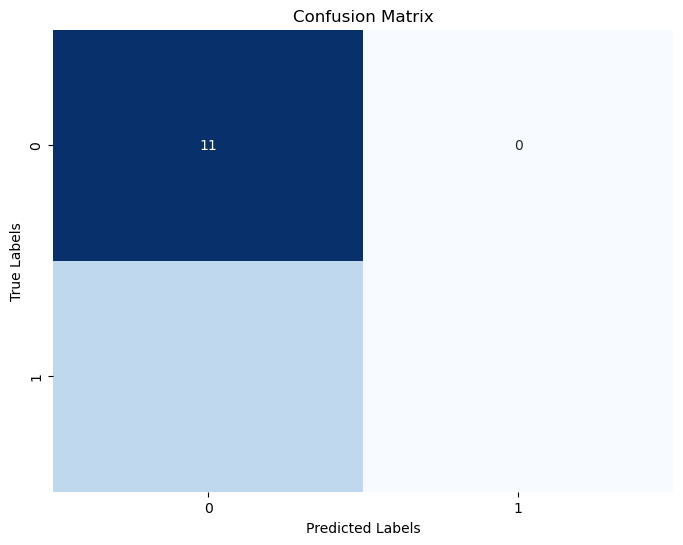

In [102]:
evaluate_model(model, X_test, y_test)